# [CSC8101] Big Data Analytics - 2022 Spark Coursework

## Coursework overview

### Inputs

- **New York City Taxi Trips dataset** - list of recorded taxi trips, each with several characteristics, namely: distance, number of passengers, origin zone, destination zone and trip cost (total amount charged to customer).
- **New York City Zones dataset** - list of zones wherein trips can originate/terminate.

### Tasks

1. Data cleaning
  1. Remove "0 distance" and 'no passengers' records.
  2. Remove outlier records. 
2. Add new columns
  1. Join with zones dataset
  2. Compute the unit profitability of each trip
3. Zone summarisation and ranking
  1. Summarise trip data per zone
  2. Obtain the top 10 ranks according to:
    1. The total trip volume
    2. Their average profitabilitiy
    3. The total passenger volume
4. Record the total and task-specific execution times for each dataset size and format.

### How to

###### Code structure and implementation

- You must implement your solution to each task in the provided function code skeleton.
- The task-specific functions are combined together to form the full pipeline code, executed last (do not modify this code).
- Before implementing the specified function skeleton, you should develop and test your solution on separate code cells (create and destroy cells as needed).

###### Development

- Develop an initial working solution for the 'S' dataset and only then optimise it for larger dataset sizes.
- To perform vectorised operations on a DataFrame:
  - use the API docs to look for existing vectorised functions in: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions
  - if a customised function is required (e.g. to add a new column based on a linear combination of other columns), implement your own User Defined Function (UDF). See:  https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html
- Use only the `pyspark.sql` API - documentation link below - (note that searching through the docs returns results from the `pyspark.sql` API together with the `pyspark.pandas` API):
  - https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.sql.html
- Always backup your solution in a separate file or your personal computer.
 
###### Execution time measurement

- Execution time is calculated and returned by the Spark Engine and shown in the output region of the cell.
- To measure the execution time of a task you must perform a `collect` or similar operation (e.g. `take`) on the returned DataFrame.

## Task 0 - Read data

The code below is ready to run. **Do not modify this code**. It does the following:

- Reads the 'zones' dataset into variable 'zone_names'
- Defines the `init_trips` function that allows you to read the 'trips' dataset (from the DBFS FileStore) given the dataset size ('S' to 'XXL') and format ('parquet' or 'delta') as function arguments
- Defines the `pipeline` function, called in Task 4 to measure the execution time of the entire data processing pipeline
- Shows you how to call the `init_trips` function and display dataset characteristics (number of rows, schema)

In [0]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
import pandas as pd
from pyspark.sql.window import Window
from pyspark.sql.types import StructType,StructField, StringType

# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/NewcastleComputingScience/csc8101-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S', data_format = "parquet", taxi_folder = "/FileStore/tables/taxi"):     
    
    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }
    
    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None               
    
    if data_format == "parquet":
        filenames = list(map(lambda s: f'{taxi_folder}/tripdata_{s}.parquet', files[size]))
        trips_df = spark.read.parquet(filenames[0])
        
        for name in filenames[1:]:
            trips_df = trips_df.union(spark.read.parquet(name))
            
    elif data_format == "delta":
        filenames = f"{taxi_folder}/taxi-{size}-delta/"
        trips_df = spark.read.format("delta").load(filenames)
    
    else:
        print("Invalid data format. Must be one of {}".format(['parquet', 'delta']))
        return None
        
    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Format: {f}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, f = data_format, ds = filenames, tc = trips_df.count()))
    
    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)
    
    return([_top10_trips, _top10_profit, _top10_passenger])

In [0]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'S'
DATA_FORMAT = 'delta'

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)

# uncomment line only for small datasets
# display(trips.take(10))

Trips dataset loaded!
 ---
 Size: S
 Format: delta
 Tables loaded: /FileStore/tables/taxi/taxi-S-delta/
 Number of trips (dataset rows): 2,898,033

In [0]:
print_count(trips)

Row count: 2,898,033

In [0]:
# dataset schemas
trips.printSchema()
zone_names.printSchema()

root
-- index: long (nullable = true)
-- VendorID: double (nullable = true)
-- tpep_pickup_datetime: string (nullable = true)
-- tpep_dropoff_datetime: string (nullable = true)
-- passenger_count: double (nullable = true)
-- trip_distance: double (nullable = true)
-- RatecodeID: double (nullable = true)
-- store_and_fwd_flag: string (nullable = true)
-- PULocationID: long (nullable = true)
-- DOLocationID: long (nullable = true)
-- payment_type: double (nullable = true)
-- fare_amount: double (nullable = true)
-- extra: double (nullable = true)
-- mta_tax: double (nullable = true)
-- tip_amount: double (nullable = true)
-- tolls_amount: double (nullable = true)
-- improvement_surcharge: double (nullable = true)
-- total_amount: double (nullable = true)
-- congestion_surcharge: double (nullable = true)
-- cab_type: string (nullable = true)
-- lpep_pickup_datetime: string (nullable = true)
-- lpep_dropoff_datetime: string (nullable = true)
-- ehail_fee: double (nullable = true)
-- trip_type: double (nullable = true)

root
-- LocationID: long (nullable = true)
-- Borough: string (nullable = true)
-- Zone: string (nullable = true)
-- service_zone: string (nullable = true)

## Task 1 - Filter rows

**Input:** trips dataset

### Task 1.1 - Remove "0 distance" and 'no passengers' records

Remove dataset rows that represent invalid trips:

- Trips where `trip_distance == 0` (no distance travelled)
- Trips where `passenger_count == 0` and `total_amount == 0` (we want to retain records where `total_amount` > 0 - these may be significant as the taxi may have carried some parcel, for example)

Altogether, a record is removed if it satisfies the following conditions:

`trip_distance == 0` or `(passenger_count == 0` and `total_amount == 0)`.

**Recommended:** Select only the relevant dataset columns for this and subsequent tasks: `['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')]`

### Task 1.2 - Remove outliers using the modified z-score

Despite having removed spurious "zero passengers" trips in task 1.1, columns `total_amount` and `trip_distance` contain additional outlier values that must be identified and removed.

To identify and remove outliers, you will use the modified [z-score](https://en.wikipedia.org/wiki/Standard_score) method.
The modified z-score uses the median and [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD), instead of the mean and standard deviation, to determine how far an observation (indexed by i) is from the mean:

$$z_i = \frac{x_i - \mathit{median}(\mathbf{x})}{\mathbf{MAD}},$$

where x represents the input vector, xi is an element of x and zi is its corresponding z-score. In turn, the MAD formula is:

$$\mathbf{MAD} = 1.438 * \mathit{median}(\big\lvert x_i - \mathit{median}(\mathbf{x})\big\rvert).$$

Observations with **high** (absolute) z-score are considered outlier observations. A score is considered **high** if its __absolute z-score__ is larger than a threshold T = 3.5:

$$\big\lvert z_i \big\rvert > 3.5.$$

where T represents the number of unit standard deviations beyond which a score is considered an outlier ([wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

This process is repeated twice, once for each of the columns `total_amount` and `trip_distance` (in any order).

**Important:** Use the surrogate function [`percentile_approx`](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.functions.percentile_approx.html?highlight=percentile#pyspark.sql.functions.percentile_approx) to estimate the median (calculating the median values for a column is expensive as it cannot be parallelised efficiently).

In [0]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below
display(trips)

index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,cab_type,lpep_pickup_datetime,lpep_dropoff_datetime,ehail_fee,trip_type
0,1.0,2021-07-01 00:08:51,2021-07-01 00:13:05,1.0,0.8,1.0,N,90,68,1.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5,Y,null,null,null,null
1,1.0,2021-07-01 00:22:39,2021-07-01 00:25:58,1.0,0.9,1.0,N,113,90,2.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5,Y,null,null,null,null
2,1.0,2021-07-01 00:48:33,2021-07-01 00:54:58,1.0,2.8,1.0,N,88,232,2.0,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,Y,null,null,null,null
3,1.0,2021-07-01 00:59:44,2021-07-01 01:07:09,1.0,1.4,1.0,N,79,249,1.0,7.0,3.0,0.5,1.5,0.0,0.3,12.3,2.5,Y,null,null,null,null
4,1.0,2021-07-01 00:08:35,2021-07-01 00:16:28,0.0,2.0,1.0,N,142,238,1.0,8.5,3.0,0.5,0.0,0.0,0.3,12.3,2.5,Y,null,null,null,null
5,1.0,2021-07-01 00:10:49,2021-07-01 00:18:42,1.0,1.6,1.0,N,114,90,1.0,7.5,3.0,0.5,1.5,0.0,0.3,12.8,2.5,Y,null,null,null,null
6,1.0,2021-07-01 00:28:56,2021-07-01 00:36:11,1.0,1.8,1.0,N,90,144,1.0,7.5,3.0,0.5,2.0,0.0,0.3,13.3,2.5,Y,null,null,null,null
7,1.0,2021-07-01 00:45:10,2021-07-01 00:52:46,1.0,2.0,1.0,N,114,48,1.0,8.5,3.0,0.5,2.45,0.0,0.3,14.75,2.5,Y,null,null,null,null
8,1.0,2021-07-01 00:55:43,2021-07-01 01:10:56,1.0,5.7,1.0,N,48,152,2.0,18.5,3.0,0.5,0.0,0.0,0.3,22.3,2.5,Y,null,null,null,null
9,1.0,2021-07-01 00:04:24,2021-07-01 00:13:23,1.0,1.8,1.0,N,234,148,1.0,8.5,3.0,0.5,2.45,0.0,0.3,14.75,2.5,Y,null,null,null,null


In [0]:
display(zone_names)

LocationID,Borough,Zone,service_zone
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone
6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone
7,Queens,Astoria,Boro Zone
8,Queens,Astoria Park,Boro Zone
9,Queens,Auburndale,Boro Zone
10,Queens,Baisley Park,Boro Zone


#### Task 1.1 
- Removing all the rows which has trip distance equal to zero and rows having either passenger count equal to zero or total amount less than or equal to zero.

In [0]:
# Your solution implementation to task 1.1 goes HERE
def t11_remove_zeros(df):
    # input: trips dataset
    cols = ['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']
    df = df.select(*cols)
    df = df.filter(df.trip_distance!=0) 
    df = df.filter((df.passenger_count!=0) |(df.total_amount>0))    
#     df = df.filter(~((df.trip_distance == 0) | ((df.passenger_count == 0) & (df.total_amount <= 0))))
    return df

In [0]:
# execute task 1.1
trips_11 = t11_remove_zeros(trips)

print_count(trips_11)
## uncomment only for smaller datasets
# display(trips_11.take(10))

Row count: 2,858,133

#### Task 1.2
- Removing outliers based on z value. If the absolute `z score` of a particular row is greater than 3.5 it will be removed. 
- Following one of the **SOLID** design principles that is **S**ingle responsibility (each function/class should implement single functionality), hence created separate functions for MAD and Z-score.
- To do this task 2 helper functions are created; `MAD()` -> Calculates the `median absolute deviation` and `z_score()` -> that calculates the `z score` for each rows and both of these functions are being called in `t12_remove_outliers()`

In [0]:
def MAD(df):

    total_amount_median = df.agg(pf.percentile_approx("total_amount", 0.5)).collect()[0][0] # median of total_amount column (single value)
    trip_distance_median = df.agg(pf.percentile_approx("trip_distance", 0.5)).collect()[0][0] # median of trip_distance column (single value)
    total_amount_MAD = 1.438*df.agg(pf.percentile_approx(pf.abs(df.total_amount - total_amount_median), 0.5)).collect()[0][0] # MAD value of total amount calculated using the formula given above (single value)
    trip_distance_MAD = 1.438*df.agg(pf.percentile_approx(pf.abs(df.trip_distance - trip_distance_median), 0.5)).collect()[0][0] # MAD value of trip distance calculated using the formula given above (single value)
    
    return total_amount_median, total_amount_MAD, trip_distance_median, trip_distance_MAD

In [0]:
def z_score(df, total_amount_median, total_amount_MAD, trip_distance_median, trip_distance_MAD):
    z_total_amount = (df.total_amount - total_amount_median)/total_amount_MAD # Column with z score calculated based on total amount
    z_trip_distance = (df.trip_distance - trip_distance_median)/trip_distance_MAD # Column with z score calculated based on trip distance
    
    return z_total_amount, z_trip_distance

In [0]:
# Your solution implementation to task 1.2 goes HERE
def t12_remove_outliers(df):
  
    total_amount_median, total_amount_MAD, trip_distance_median, trip_distance_MAD = MAD(df) # calling MAD function created above
    z_total_amount, z_trip_distance = z_score(df, total_amount_median, total_amount_MAD, trip_distance_median, trip_distance_MAD) # calling z_score function created above
    df = df.withColumn('z_total_amount', z_total_amount) # renaming the column
    df = df.withColumn('z_trip_distance', z_trip_distance) # renaming the column
    df = df.filter(pf.abs(df.z_total_amount) <= 3.5) # removing the rows which are having z_score more than 3.5
    df = df.filter(pf.abs(df.z_trip_distance) <= 3.5) # removing the rows which are having z_score more than 3.5
    return df

In [0]:
# execute task 1.2
trips_12 = t12_remove_outliers(trips_11)
print_count(trips_12)
# display(trips_12.take(10))

Row count: 2,483,577

In [0]:
display(trips_11)

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
90,68,0.8,1.0,8.8
113,90,0.9,1.0,8.8
88,232,2.8,1.0,13.8
79,249,1.4,1.0,12.3
142,238,2.0,0.0,12.3
114,90,1.6,1.0,12.8
90,144,1.8,1.0,13.3
114,48,2.0,1.0,14.75
48,152,5.7,1.0,22.3
234,148,1.8,1.0,14.75


## Task 2 - Compute new columns

### Task 2.1 - Zone names

Obtain the **start** and **end** zone names of each trip by joining the `trips` and `zone_names` datasets (i.e. by using the `zone_names` dataset as lookup table).

**Note:** The columns containing the start and end zone ids of each trip are named `PULocationID` and `DOLocationID`, respectively.

### Task 2.2 - Unit profitability

Compute the column `unit_profitabilty = total_amount / trip_distance`.

In [0]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

- To get the zone name based on Pick-up location ID and Drop-off location ID, dataframe from task 1.2 has been left joined with `zone_name` dataframe and column name for pick-up zone is `start` and for drop-off zone is `stop`

In [0]:
# Your solution implementation to task 2.1 goes HERE
def t21_join_zones(df, zones_df = zone_names):
    # input: output of task 1.2 and zone_names dataset
    df = df.join(zones_df.select("LocationID","Zone"),df['PULocationID'] == zones_df['LocationID'], how='left') # left join on locationID from zone_df and PULocationID from trip dataset...
    df = df.withColumnRenamed('Zone', 'start') # renaming the column to start...
    df = df.drop("LocationID")
    df = df.join(zones_df.select("LocationID","Zone"),df['DOLocationID'] == zones_df['LocationID'], how='left') # left join on locationID from zone_df and DOLocationID from trip dataset...
    df = df.withColumnRenamed('Zone', 'stop')  # renaming the column to stop...
    df = df.drop("LocationID")
    return df

In [0]:
# execute task 2.1
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)

print_count(trips_21)
# display(trips_21.take(10))

Row count: 2,483,577

- Calculating unit profitability which is amount per unit distance `(df.total_amount / df.trip_distance)`

In [0]:
# Your solution implementation to task 2.2 goes HERE
def t22_calc_profit(df):
    # input: output of task 2.1
    unit_profitabilty = df.total_amount / df.trip_distance
    df = df.withColumn('unit_profitabilty', unit_profitabilty)
    return df

In [0]:
# execute task 2.2
trips_22 = t22_calc_profit(trips_21)

print_count(trips_22)
# display(trips_22.take(10))

Row count: 2,483,577

## Task 3: Rank zones by traffic, passenger volume and profitability

### 3.1 - Summarise interzonal travel

Build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones. The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones. 

For example, zones Z1 and Z2 are connected by *two* edges: edge Z1 --> Z2 carries aggregate data about all trips that originated in Z1 and ended in Z2, and edge Z2 --> Z2 carries aggregate data about all trips that originated in Z2 and ended in Z1.

The aggregate information of interzonal travel must include the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitabilty)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).

This graph can be represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

__hint__: the `groupby()` operator produces a `pyspark.sql.GroupedData` structure. You can then calculate multiple aggregations from this using `pyspark.sql.GroupedData.agg()`: 
- https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.groupby.html
- https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.agg.html

### Task 3.2 - Obtain top-10 zones

For each of the following measures, report the top-10 zones _using their plain names you dereferenced in the previous step, not the codes_. Note that this requires ranking the nodes in different orders. Specifically, you need to calculate the following further aggregations:

- the **total** number of trips originating from Z. This is simply the sum of `trips_count` over all outgoing edges for Z, i.e., edges of the form Z -> \*
- the **average** profitability of a zone. This is the average of all `average_unit_profit` over all *outgoing* edges from Z.
- The **total** passenger volume measured as the **sum** of `total_passengers` carried in trips that originate from Z

In [0]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

- To get the all the unique pairs of start and stop zones, grouping the table on `PULocationID` and `DOLocationID` then calculating the average unit profitability by taking the avg of `unit_profitability`, total pasanger count by summing th `passenger_count` and total trip count by counting the `trip_distance`

In [0]:
## Your solution to task 3.1 goes HERE
def t31_summarise_trips(df):
    # input: output of task 2.2

    new_df = df.groupBy('PULocationID', 'DOLocationID').agg(pf.avg('unit_profitabilty'), pf.count('trip_distance'), pf.sum('passenger_count'))
    new_df = new_df.withColumnRenamed("avg(unit_profitabilty)", 'average_unit_profit').withColumnRenamed("count(trip_distance)", "trips_count").withColumnRenamed("sum(passenger_count)", "total_passengers")
    
    return new_df

In [0]:
display(trips_22)

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,z_total_amount,z_trip_distance,start,stop,unit_profitabilty
90,68,0.8,1.0,8.8,-1.0610720418943895,-0.8052119171363733,Flatiron,East Chelsea,11.0
113,90,0.9,1.0,8.8,-1.0610720418943895,-0.7320108337603394,Greenwich Village North,Flatiron,9.777777777777779
88,232,2.8,1.0,13.8,-0.24486277889870528,0.6588097503843054,Financial District South,Two Bridges/Seward Park,4.928571428571429
79,249,1.4,1.0,12.3,-0.48972555779741056,-0.36600541688016974,East Village,West Village,8.785714285714286
142,238,2.0,0.0,12.3,-0.48972555779741056,0.07320108337603401,Lincoln Square East,Upper West Side North,6.15
114,90,1.6,1.0,12.8,-0.40810463149784215,-0.21960325012810172,Greenwich Village South,Flatiron,8.0
90,144,1.8,1.0,13.3,-0.32648370519827374,-0.07320108337603386,Flatiron,Little Italy/NoLiTa,7.388888888888889
114,48,2.0,1.0,14.75,-0.0897830189295254,0.07320108337603401,Greenwich Village South,Clinton East,7.375
48,152,5.7,1.0,22.3,1.142692968193958,2.78164116828929,Clinton East,Manhattanville,3.912280701754386
234,148,1.8,1.0,14.75,-0.0897830189295254,-0.07320108337603386,Union Sq,Lower East Side,8.194444444444445


In [0]:
# execute task 3.1
graph = t31_summarise_trips(trips_22)

print_count(graph)
# display(graph.take(10))

Row count: 13,299

- Below code is used to find the top 10 zones which are having most number of trips, maximum profits, and large number of passenger counts.

In [0]:
# Your solution to task 3.2 goes HERE (implement each of the functions below)
def t32_summarise_zones_pairs(df, zones_df = zone_names):
    df = df.join(zones_df.select("LocationID","Zone"),df['PULocationID'] == zones_df['LocationID'], how='left')
    df = df.withColumnRenamed('Zone', 'start')
    df = df.drop("LocationID")
    df = df.join(zones_df.select("LocationID","Zone"),df['DOLocationID'] == zones_df['LocationID'], how='left')
    df = df.withColumnRenamed('Zone', 'stop')
    df = df.drop("LocationID")
    return df

# Top 10 ranked zones by traffic (trip volume)
def t32_top10_trips(df_zones):
    # input: output of task 3.2
    
    # grouping on start and summing the trip_counts and sorting in the descending order and showing top 10 rows...
    df_zones = df_zones.groupBy('start').agg(pf.sum('trips_count').alias('Trip_Counts')).sort(pf.desc('Trip_Counts')).head(10)
    return df_zones

# Top 10 ranked zones by profit
def t32_top10_profit(df_zones):
    # input: output of task 3.2
    
    # grouping on start, taking avg of avg_unit_profit then sorting in descending order and showing top 10 rows...
    df_zones = df_zones.groupBy('start').agg(pf.avg('average_unit_profit').alias('average_profitability')).sort(pf.desc('average_profitability')).head(10)
    return df_zones

# Top 10 ranked zones by passenger volume
def t32_top10_passenger(df_zones):
    # input: output of task 3.2
    
    # grouping on start, taking sum of total_passengers then sorting in descending order and showing top 10 rows...
    df_zones = df_zones.groupBy('start').agg(pf.sum('total_passengers').alias('total_passengers')).sort(pf.desc('total_passengers')).head(10)
    return df_zones

In [0]:
# execute task 3.2
zones = t32_summarise_zones_pairs(graph)

top10_trips     = t32_top10_trips(zones)
top10_profit    = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)

In [0]:
display(zones)

PULocationID,DOLocationID,average_unit_profit,trips_count,total_passengers,start,stop
29,149,6.979548748975862,2,3.0,Brighton Beach,Madison
26,26,19.718782372888125,87,12.0,Borough Park,Borough Park
26,227,13.736003592717939,10,2.0,Borough Park,Sunset Park East
26,89,9.049297841507073,9,2.0,Borough Park,Flatbush/Ditmas Park
26,85,7.016426729322668,4,5.0,Borough Park,Erasmus
29,29,20.315648480979206,8,2.0,Brighton Beach,Brighton Beach
29,150,13.535431540997354,10,1.0,Brighton Beach,Manhattan Beach
29,155,5.69182764619998,3,5.0,Brighton Beach,Marine Park/Mill Basin
29,227,4.263473053892215,1,null,Brighton Beach,Sunset Park East
26,111,20.636363636363637,1,null,Borough Park,Green-Wood Cemetery


In [0]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
display(top10_trips)

start,Trip_Counts
Upper East Side South,122096
Upper East Side North,103951
Penn Station/Madison Sq West,96933
Midtown Center,93776
Murray Hill,88617
Midtown East,85316
Lincoln Square East,81103
Upper West Side South,74910
Clinton East,74673
Lenox Hill West,74439


In [0]:
# use 'display()' return a pandas DataFrame for 'pretty' output
display(top10_profit)

start,average_profitability
Bay Terrace/Fort Totten,311.9330683658483
Baisley Park,100.00592710440851
Prospect Park,93.05468065107412
Saint Michaels Cemetery/Woodside,74.82831383792275
Van Cortlandt Village,48.74415903037328
Grymes Hill/Clifton,38.65
Crotona Park,36.84437137879827
Flatbush/Ditmas Park,33.88362306081024
Eastchester,32.08567975083938
Flushing Meadows-Corona Park,29.564931153882387


In [0]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
display(top10_passenger)

start,total_passengers
Upper East Side South,170285.0
Upper East Side North,144281.0
Penn Station/Madison Sq West,137494.0
Midtown Center,135150.0
Murray Hill,124088.0
Midtown East,120019.0
Lincoln Square East,114953.0
Clinton East,107395.0
Upper West Side South,106149.0
East Village,105818.0


## Task 4 - Record the pipeline's execution time

Record the execution time of:

1. the whole pipeline
2. the whole pipeline except task 1.2

on the two tables below, for all dataset sizes: `'S'`, `'M'`, `'L'`, `'XL'`, `'XXL'`, and data formats: `parquet` and `delta`.

Analyse the resulting execution times and comment on the effect of dataset size, dataset format and task complexity (with and without task 1.2) on pipeline performance.

In [0]:
# after developing your solution, it may be convenient to combine all your functions in a single cell (at the start or end of the notebook)

# CHANGE the value of the following arguments to record the pipeline execution times for increasing dataset sizes
SIZE = 'XXL'
DATA_FORMAT = 'delta'
WITH_TASK_12 = False

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)

Trips dataset loaded!
 ---
 Size: XXL
 Format: delta
 Tables loaded: /FileStore/tables/taxi/taxi-XXL-delta/
 Number of trips (dataset rows): 132,396,785

- Below code runs the whole pipeline removing zeros > removing outliers > adding zone names > calculating unit profitability > dataframe with start and end zone pair > calculating passanger count, avg unit profitability, and total trips > finding top 10 zones for passanger count, unit profitability and total trips.

In [0]:
# run and record the resulting execution time shown by databricks (on the cell footer)

# IMPORTANT: this function calls all task functions in order of occurrence. For this code to run without errors, you have to load into memory all of the previous task-specific functions, even if you haven't implemented these yet.
pipeline(trips, with_task_12 = WITH_TASK_12)

Out[30]: [[Row(start='Upper East Side South', Trip_Counts=5547011),
 Row(start='Upper East Side North', Trip_Counts=5116480),
 Row(start='Midtown Center', Trip_Counts=4874992),
 Row(start='Penn Station/Madison Sq West', Trip_Counts=4366447),
 Row(start='Midtown East', Trip_Counts=4307043),
 Row(start='Times Sq/Theatre District', Trip_Counts=3844450),
 Row(start='Murray Hill', Trip_Counts=3813411),
 Row(start='Clinton East', Trip_Counts=3780338),
 Row(start='Lincoln Square East', Trip_Counts=3738256),
 Row(start='JFK Airport', Trip_Counts=3697885)],
 [Row(start='Newark Airport', average_profitability=75.1930759842642),
 Row(start='Arden Heights', average_profitability=38.11952040113716),
 Row(start='Forest Park/Highland Park', average_profitability=17.840361244627346),
 Row(start=None, average_profitability=15.929635403944006),
 Row(start="Eltingville/Annadale/Prince's Bay", average_profitability=15.85021430917414),
 Row(start='Rossville/Woodrow', average_profitability=15.450854439425232),
 Row(start='New Dorp/Midland Beach', average_profitability=14.894519854525143),
 Row(start='NV', average_profitability=14.687994941683193),
 Row(start='Highbridge Park', average_profitability=13.83832247198784),
 Row(start='Queens Village', average_profitability=13.757510056734267)],
 [Row(start='Upper East Side South', total_passengers=8265045.0),
 Row(start='Upper East Side North', total_passengers=7626015.0),
 Row(start='Midtown Center', total_passengers=7456960.0),
 Row(start='Penn Station/Madison Sq West', total_passengers=6523834.0),
 Row(start='Midtown East', total_passengers=6472875.0),
 Row(start='Times Sq/Theatre District', total_passengers=6100483.0),
 Row(start='Clinton East', total_passengers=5816084.0),
 Row(start='JFK Airport', total_passengers=5803297.0),
 Row(start='Lincoln Square East', total_passengers=5694922.0),
 Row(start='Murray Hill', total_passengers=5691669.0)]]

- Following 2 tables show the time taken by the whole data processing pipeline on different size of data in different data formats like parquet and delta.
- Delta times are faster than parquet because delta format is been developed by databricks and is very optimized on their platform.

_Table 1. Pipeline performance for `parquet` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.9 |  15.5 |  41.9 |  90.5 |  132.4 |
| execution time   (w/o 1.2)  | 7.68 seconds| 1.76 minutes| 17.37 minutes| 24.07 minutes | 27.31 minutes |
| execution time              | 17.72 seconds | 3.65 minutes | 33.37 minutes| 49.53 minutes | 48.84 minutes |
| sec / 1M records (w/o 1.2)  | 2.64  | 6.77  | 24.868 | 15.91 | 12.37  |
| sec / 1M records            | 6.11  | 14.12  | 47.78  |32.82  | 22.12  |

_Table 2. Pipeline performance for `delta` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.9 |  15.5 |  41.9 |  90.5 |  132.4 |
| execution time   (w/o 1.2)  |   6.75 seconds| 10.99 seconds | 10.08 seconds |  16.82 seconds | 23.66 seconds |
| execution time              | 10.69 seconds| 19.54 seconds| 23.07 seconds | 47.16 seconds |1.05 minutes|
| sec / 1M records (w/o 1.2)  | 2.32| 0.709 | 0.24  | 0.185 | 0.178  |
| sec / 1M records            | 3.68  | 1.26  | 2.288 | 0.521 | 0.475 |

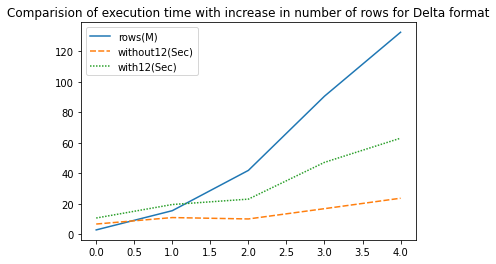

In [0]:
rows = [2.9, 15.5, 41.9, 90.5, 132.4]
without12 = [6.75, 10.99, 10.08, 16.82, 23.66]
with12 = [10.69, 19.54, 23.07, 47.16, 63]

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

time_df_delta = pd.DataFrame([rows, without12, with12])
time_df_delta = time_df_delta.T
time_df_delta.columns = ['rows(M)', 'without12(Sec)', 'with12(Sec)']

sns.lineplot(data=time_df_delta)
plt.title('Comparision of execution time with increase in number of rows for Delta format')
plt.show()

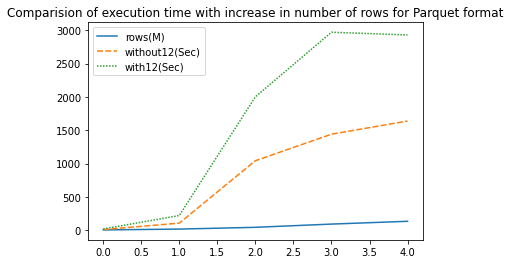

In [0]:
rows = [2.9, 15.5, 41.9, 90.5, 132.4]
without12 = [7.68, 105, 1042, 1440, 1638]
with12 = [17.72, 219, 2002, 2971, 2930]

time_df_delta = pd.DataFrame([rows, without12, with12])
time_df_delta = time_df_delta.T
time_df_delta.columns = ['rows(M)', 'without12(Sec)', 'with12(Sec)']

sns.lineplot(data=time_df_delta)
plt.title('Comparision of execution time with increase in number of rows for Parquet format')
plt.show()